In [292]:
import nltk
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from time import sleep

import os
import requests
import json
import re 
import shutil

import pickle
from textblob import TextBlob
from sklearn import metrics
from sklearn.preprocessing import minmax_scale
from textblob import Word

import tensorflow as tf
#from geopy.geocoders import Nominatim 

import statsmodels.api as sm

# Summary

To get your Factiva pdfs into a machine readable format (.txt) move them into this folder and run the cell under the heading 'Reading In PDF Data'. To get individual files as dataframes, run all cells and then pass the file you want to the factiva_parser function:

my_dataframe = factiva_parser('My_File.txt')

## Very Quick Python Review

### Notebooks

In a Jupyter Notebook, information is contained in vertically stacked 'cells' that can be used to either display text (like this cell) by selecting the Markdown option from the dropdown menu beneath the tabs at the top of the window or perform Python operations by selecting the Code option from the same drop down. A third option designated 'Raw' also allows for the display of text, but without Markdown formatting. Cells can be edited by double clicking within the cells. Cells are executed either by clicking the arrow to the left of the cell dropdown menu used earlier or by using the shortcut 'Ctrl + Enter'

In [2]:
# This cell is rendering code so anything we do not want to be evaluated must be prefaced by a '#' which is referred to as commenting out code.

# Uncommented code is evaluated by the Python interpreter as seen below
2 + 2

4

### Python Data Types and Basic Structures

As we saw above, the python interpreter can take input, perform operations on that input, and return output. There are few limits to the types of operations that can be performed on input, but there are a finite number of ways that input can be represented in Python so we will go over a couple of them here. The most common ways data are represented are int, float, str, and datetime. Any type of data can be stored in a variable which is a name that you give to the data.

In [3]:
print('This is an int: ', 1)
print('This is a float: ', 1.01)
print('This is a string: ', 'Hello')
print('This is a datetime: ', dt.now())

This is an int:  1
This is a float:  1.01
This is a string:  Hello
This is a datetime:  2021-03-25 07:18:19.154571


In [4]:
# We can assign our data to variable names to call upon them later using the '=' operator.

my_integer = 1
my_float = 1.01
my_string = 'Hello'
a_moment_in_time = dt.now()


Note that when the above cell is run, nothing was printed below the cell. This is because we never performed any action in the cell that would return output. We were only assigning names to certain data values. We can reference those names now and the Python interpreter will return the data that the name refers to.

In [5]:
a_moment_in_time

datetime.datetime(2021, 3, 25, 7, 18, 19, 325286)

### Lists, Tuples, and Dictionaries

These data can be arranged into several different types of structures in Python. The most basic is called a list and is created using brackets. This is useful for organizing data that you may want to treat in a unified way in the future. Lists are indexed and items can be added to or removed from the list after its creation (the list is said to be mutable). Tuples are very similar to lists except that they are not mutable and are instantiated using parentheses.

In [6]:
my_list = [my_integer, my_float, my_string, a_moment_in_time]
print(my_list)

my_tuple = (my_integer, my_float, my_string, a_moment_in_time)
print(my_tuple)

my_list[0]

[1, 1.01, 'Hello', datetime.datetime(2021, 3, 25, 7, 18, 19, 325286)]
(1, 1.01, 'Hello', datetime.datetime(2021, 3, 25, 7, 18, 19, 325286))


1

Dictionaries are Pythons implementation of hash tables. Hash tables are data structures that relate named keys to certain values, known as a key-value pair. This is fundamentally different from lists or tuples in that the indexes are no longer positional, but rather indexed by the key. This key can be thought of as similar to a variable name that references the value inside the dictionary. Dictionaries are instantiated using curly brackets with keys and values being related using semicolons.

In [7]:
my_dictionary = {'first_key':1, 'second_key':2, 'you_can_put_whatever_you_want':'for_either_key_or_value'}

print(my_dictionary['first_key'])
print(my_dictionary['you_can_put_whatever_you_want'])

1
for_either_key_or_value


It is worth noting that .json files can be represented in Python as nested dictionaries.

### Pandas and Numpy Arrays

The most common way to handle larger amounts of data inside python is in a pandas dataframe. This can be thought of as pythons version of an Excel table or spreadsheet. It is comprised of columns and rows with the convention being that each column is a variable and each row is an observation. There are many different ways to create dataframes, but the most common is to read in from a csv file using pd.read_csv(). Pandas dataframes are very robust ways to manipulate data but have some important differences from simpler data structures. 

* Columns may contain different data types as in lists or tuples, but this can cause problems when attempting to perform full column calculations
* Pandas dataframes can be indexed by either name or location using the .loc and .iloc methods respectively
* Pandas contains many ways to manipulate the data inside dataframes, which creates overhead. Pandas dataframes will be slightly slower than simpler representations of data, such as lists, or arrays

Numpy arrays are vectorized matrices that allow for increased computational efficiency compared to pandas dataframes. They are MUCH less flexible than pandas dataframes in terms of what operations they allow and are mostly used for more complex mathematics.

In [8]:
my_df = pd.DataFrame({'column1':[1, 2, 3],
                      'column2':['two_types', 'of_data', 1],
                      'descriptive_col_name':['all', 'the', 'strings']})

my_df

,column1,column2,descriptive_col_name
0,1,two_types,all
1,2,of_data,the
2,3,1,strings


### Logic and Control Flow

Python has a number of different operations that allow you to add more complex behavior to your python code. Two of these ways are conditionals and control flow statements. Conditionals evaluate some True-False statement and execute different segments of code depending on the result. Control flow statements allow you rerun a block of code a set number of times. The two most common implementations of conditionals and control flow are 'if-else' statements and for loops resepctively.

In [9]:
x = {'cat':'small', 'elephant':'large','dog':'in-between'}

for i in x:
    if x[i]=='large':
        print('It stays outside')
    else:
        print('Bring it on in')

Bring it on in
It stays outside
Bring it on in


Above we see that the if statement evaluated whether the value associated with key contained the string 'large'. If it evaluated as True, the first output was returned; otherwise the second value was returned. The for loop allowed this evaluation to be performed for every key value in the dictionary x.

## Reading in PDF Data

The following cell reads all available .pdf files in the local directory and converts the well formatted files into .txt files which are more amenable to processing.

In [4]:
#for root, dirs, files in os.walk("."):
#    for filename in files:
#        if filename.endswith('.pdf'):
#            !pdftotext {filename}

from nltk.corpus import stopwords
stop = stopwords.words('english')

## Parsing Factiva Data

Its a good idea to look at the raw text data to make sure it looks similar to the pdf file. Improperly formatted pdf files can be difficult or impossible to convert to machine readable format. Since we are primarily pulling from a single source this shouldn't be a problem but it is important to be aware of the potential issue if using pdf's from other sources. 

In [5]:
f =  open('./JnJ80_84.txt', 'r')  
factiva_raw = f.readlines()
f.close()

factiva_raw[:20]


['Marketing has looked at the succesful PR re-launch of the Johnson and Johnson drug Tylenol. .................................5\n',
 "Johnson and Johnson's Tylenol analgesic capsules have staged a dramatic recovery since seven people in Chicago\n",
 'died after taking Tylenol... ...............................................................................................................................................6\n',
 'Johnson and Johnson has reported net earnings of $150.3m, or 79 cents a share, for the third quarter of 1983. ..........\n',
 '7\n',
 'No Headline ....................................................................................................................................................................8\n',
 'Companies and Markets: Drug problems hit Johnson &Johnson ...................................................................................9\n',
 'JOHNSON & JOHNSON 3RD QTR NET 79C A SHARE VS. OPER. NET 78C ........................................

----------



It looks like we have successfully read in the pdf file into a text file. Notice that when using the readlines method, the output is a list with each line getting it's own entry in the list. The newline character '\n' is also left uninterpreted and included in the output. Both of these observations will be important to recognize during processing.

We now have the data from Factiva in a text file but before we can start to extract information from it we must first convert it to a more organized structure. We will do this by parsing the text using regular expressions. Regular expressions are patterns that allow the user to specify patterns of strings that the regular expression will match. This will allow us to identify useful parts of the text and arrange them accordingly. Regular expressions can be hard interpret due to their concise notation, but a good intro to them and their use can be found at https://docs.python.org/3/library/re.html

We will start by building functions that use regular expressions to extract

In [6]:
def get_titles(factiva_by_lines):
    
    
    # The re expressions used here were created by identifying common patterns present in 
    # the Factiva formatting.
    title_end = re.compile('\.+\d{1,4}\\n')
    new_line = re.compile('\D\\n')
    article_start = re.compile('\d{1,3} words$')
    
    # 
    current = ''
    titles = []
    
    for line in factiva_by_lines:
        
        regex_end = title_end.search(line)
        regex_new = new_line.search(line)
        regex_break = article_start.search(line)
        
        # Detects if the title portion has ended and breaks the loop if so
        if regex_break:
            break
            
        # Handles titles that don't fit on one line
        if regex_new:
            current += line[:regex_new.span()[0]+1]
            continue
        
        if regex_end:
            
            # Strips all the dots from the title using the indices in the regular expression
            title = line[:regex_end.span()[0]]
            current += title
            titles.append(current)
            current = ''
    
    return titles

In [7]:
def get_articles(factiva_by_lines):
    lines = []
    article = ''
    articles = []
    
    article_flag = 0
    
    # searches for the common date format at the beginning of each article
    regex_date = re.compile('^[0-9]?[0-9] (January|February|March|April|May|June|July|August|September|October|November|December) [0-9][0-9][0-9][0-9]$')
    # searches for the document end code
    regex_end = re.compile('^Document \S{25}')
    
    for i in factiva_by_lines:
        article_start = regex_date.search(i)
        article_end = regex_end.search(i)
        
        if article_start:
            article_flag = 1
        if article_end:
            articles.append(article)
            article = ''
            article_flag = 0
        if article_flag:
            article += i
    
    
    return articles

In [8]:
def get_factiva_title(folder='Eaddy_Factiva'):
    for _, _, files in os.walk('Eaddy_Factiva'):
        for filename in files:
            if filename.endswith('.pdf'):
                print(filename)
        break

def factiva_parser(factiva_txt, stopwords=stop):
    f =  open(factiva_txt, 'r')  
    factiva_raw = f.readlines()
    f.close()
    
    titles = get_titles(factiva_raw)
    articles = get_articles(factiva_raw)
    
    df = pd.DataFrame({'titles':titles, 'articles':articles})
    
    # Preprocessing
    # lowercase
    df['articles'] = df['articles'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    # symbols
    df['articles'] = df['articles'].str.replace('[^\w\s]','', regex=True) 
    # stopwords
    df['articles'] = df['articles'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
    # common Words
    freq = pd.Series(' '.join(df['articles']).split()).value_counts()[:10]
    print(freq)
    #df['articles'] = df['articles'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    # lemmatization
    df['articles'] = df['articles'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    
    return df

In [9]:
factiva_df = factiva_parser('./JnJ80_84.txt')

tylenol     471
johnson     408
said        331
company     272
new         224
million     195
capsules    189
1982        145
sales       142
market      129
dtype: int64


In [10]:
factiva_df['articles'] = factiva_df['articles'].apply(lambda x: x.replace('\n', ' '))

Text(0, 0.5, 'Scaling Factor')

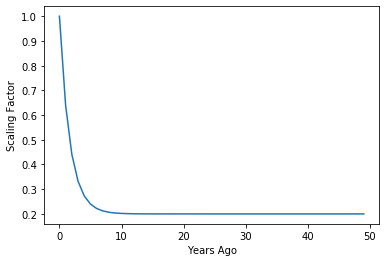

In [11]:
# Corpus Scope vs Article Scope
def fy(x, floor=0.2, shape=.6):
    return ((1/np.exp(x*shape))*(1-floor) + floor)

x = list(range(50))
y = [fy(i) for i in x]
plt.plot(x,y)
plt.xlabel('Years Ago')
plt.ylabel('Scaling Factor')



### NRC Lexicon

In [12]:
filepath = "./Eaddy_Factiva/NRC-Suite-of-Sentiment-Emotion-Lexicons/NRC-Suite-of-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], sep='\t')
emolex_df.head(20)

,word,emotion,association
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0
5,aback,negative,0
6,aback,positive,0
7,aback,sadness,0
8,aback,surprise,0
9,aback,trust,0


## Salience Factors

In [13]:
def time_decay_fx(x, floor=0.5, shape=0.5):
    return ((1/np.exp(x*shape))*(1-floor) + floor)

def get_valence(article):
    sentiment, subjectivity = TextBlob(article).sentiment
    return sentiment

def get_factiva_date(article):
    regex_date = re.compile('^[0-9]?[0-9] (january|february|march|april|may|june|july|august|september|october|november|december) [0-9][0-9][0-9][0-9]')
    date = regex_date.search(article)
    date = dt.strptime(date[0], '%d %B %Y')
    return date

def get_factiva_proximity(article, time_decay_params):
    
    now = dt.now()
    date = get_factiva_date(article)
    yrs_ago = (now-date).days/365
    time_decay = time_decay_fx(yrs_ago, time_decay_params)
    
    # In the future maybe use machine learning to contextually identify locations. 
    return time_decay
    


def get_crisis_emotions(article,nrc_df=emolex_df):
    # Need to associate negative and positive with the words they correspond to and modify meaning accordingly
    article_dict = {'anger':0,
                    'negative':0,
                    'positive':0,
                    'anticipation':0,
                    'disgust':0,
                    'fear':0,
                    'joy':0,
                    'sadness':0,
                    'surprise':0,
                    'trust':0}
    nrc_words = pd.unique(nrc_df['word'])
    article_words =nltk.word_tokenize(article)
    
    # instead of iterating, make it vectorized for improved performance
    for i in article_words:
        if i in nrc_words:
            subset = nrc_df[nrc_df['word']==i]
            for j in range(subset.shape[0]):
                idx = min(subset.index)
                key = subset.loc[idx+j,'emotion']
                val = subset.loc[idx+j, 'association']
                article_dict[key] += val
    article_dict['total'] = len(article_words)
    return article_dict
            
    
    
# get_crisis_type will difficult as that is obfuscated by fluid subject object relationships when identifying victimhood.
#def get_crisis_type(article):
    #return

In [14]:
get_crisis_emotions(factiva_df.iloc[0,1])

{'anger': 3,
 'negative': 8,
 'positive': 7,
 'anticipation': 4,
 'disgust': 4,
 'fear': 7,
 'joy': 3,
 'sadness': 4,
 'surprise': 2,
 'trust': 4,
 'total': 81}

In [15]:
factiva_df['Date'] = factiva_df['articles'].apply(get_factiva_date)

In [16]:
print((dt.now()- get_factiva_date(factiva_df.iloc[0,1])).days/365)
print(get_factiva_date(factiva_df.iloc[0,1]))
get_factiva_date(factiva_df.iloc[0,1])

37.43013698630137
1983-12-02 00:00:00


datetime.datetime(1983, 12, 2, 0, 0)

In [17]:
factiva_df

,titles,articles,Date
0,Marketing has looked at the succesful PR re-la...,2 december 1983 marketing mktg 12 english c 19...,1983-12-02
1,Johnson and Johnson's Tylenol analgesic capsul...,25 november 1983 campaign cmpn 8 english c 198...,1983-11-25
2,Johnson and Johnson has reported net earnings ...,28 october 1983 financial time ftft 25 english...,1983-10-28
3,Companies and Markets: Drug problems hit Johns...,28 october 1983 new york time nytf late city f...,1983-10-28
4,JOHNSON & JOHNSON 3RD QTR NET 79C A SHARE VS. ...,28 october 1983 financial time ftft page 17 en...,1983-10-28
...,...,...,...
93,TYLENOL COUPONS TO BE MAILED NATIONALLY BEGINN...,18 october 1982 wall street journal j english ...,1982-10-18
94,Drug Makers Ask U.S. Rules On Packaging,15 october 1982 washington post wp english cop...,1982-10-15
95,Suspect in Tylenol Case Once Held in '78 Death,15 october 1982 new york time nytf late city f...,1982-10-15
96,LEGAL BATTLE OVER WHO IS LIABLE FOR THE TYLENO...,14 october 1982 new york time nytf late city f...,1982-10-14


(array([43., 17.,  9.,  9.,  4.,  1.,  0.,  2.,  5.,  8.]),
 array([723832. , 723873.4, 723914.8, 723956.2, 723997.6, 724039. ,
        724080.4, 724121.8, 724163.2, 724204.6, 724246. ]),
 <a list of 10 Patch objects>)

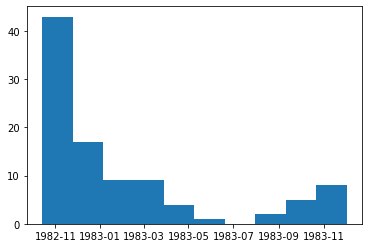

In [18]:
plt.hist(factiva_df['Date'])

In [19]:
# Hanks Ranking of every article in the 100 as a test
# done w.r.t. tone and relevance ie a negative article 
# about J&J's competitor is good

# 4 and 53 are having problems parsing. Fix the get_titles() function

def t_score(dat0, dat1):
    t = (np.mean(dat0)-np.mean(dat1))/(np.std(dat1)/np.sqrt(len(dat1)))
    return t
    

hss = [6, 8, 5, #3,
        2, 3, 4, 3, 6, 3,
      2, 2, 4, 7, 6, 4, 6, 5, 3, 4,
      6, 7, 2, 3, 2, 6, 2, 5, 4, 4,
      5, 5, 6, 6, 8, 6, 6, 5, 4, 4,
      6, 6, 7, 8, 7, 9, 8, 7, 4, 3,
      5, 4, 4, #2,
        6, 7, 7, 8, 2, 7,
      3, 6, 1, 4, 4, 6, 6, 6, 7, 6,
      4, 3, 4, 2, 6, 3, 3, 3, 6, 2,
      3, 2, 2, 1, 3, 2, 2, 1, 7, 7,
      1, 8, 5, 6, 7, 6, 5, 7, 3, 6]

hss_scaled = minmax_scale(hss, (-0.17,0.17))

factiva_df['sent_valence'] = factiva_df['articles'].apply(get_valence, 1)
factiva_df.head()
print(min(factiva_df['sent_valence']))
print(max(factiva_df['sent_valence']))
print(np.mean(factiva_df['sent_valence']))

sent_val = factiva_df['sent_valence']
print('~~~~~~')

print(min(hss))
print(max(hss))

random = np.round(minmax_scale(np.random.random(98), (.1, .9)), 1)*10
random_scaled = minmax_scale(random, (-.17,.17))
print(random)
print(metrics.mean_squared_error(hss_scaled, sent_val))
print(metrics.mean_squared_error(random_scaled, sent_val))

print(t_score(hss_scaled, sent_val))

-0.11082251082251082
0.16666666666666666
0.05481748625074361
~~~~~~
1
9
[7. 2. 9. 8. 8. 1. 6. 8. 2. 2. 2. 4. 3. 8. 8. 3. 7. 6. 7. 6. 9. 6. 6. 9.
 7. 6. 5. 1. 4. 4. 2. 3. 3. 8. 3. 9. 4. 9. 5. 8. 5. 1. 4. 7. 1. 8. 5. 6.
 8. 3. 6. 7. 4. 8. 7. 6. 7. 6. 4. 7. 3. 3. 1. 8. 9. 8. 8. 9. 9. 4. 8. 2.
 8. 4. 6. 5. 3. 7. 9. 3. 5. 4. 1. 6. 2. 2. 6. 7. 5. 3. 1. 6. 5. 3. 3. 6.
 6. 5.]
0.013759860049622362
0.014410288357952597
-12.407633450490895


In [20]:
lle_txt = pd.read_csv('LLE.csv', header=1)

In [21]:
lle_txt['Date '] = pd.to_datetime(lle_txt['Date '])

In [22]:
lle_txt

,Date,Brand Name,Product Description,Reason/Problem,Company,Current crisis valence (public perception atm) (make numeric),Crisis Type,Crisis Type Notes,Visibility,Visibility Notes,Emotion,Emotion Notes,Proximity,Proximity Notes,Stability,Stability Notes,Perspective,Perspective Notes,Keywords
0,2009-12-18,Tylenol,NaN,"must odor of pills that caused Nausea, vomitin...","McNeil Consumer Healthcare, Division of McNEIL...",2,2.0,appears to be accident crisis because it was n...,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,NaN,McNeil and recall or Johnson & Johnson
1,2010-01-01,Multiple meds,pills,expanded 12/09 recall identified the source of...,McNeil Consumer Healthcare,2,2.0,appears to be accident crisis because it was n...,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,unknown so used 2nd most recent,McNeil and recall or Johnson & Johnson
2,2010-01-15,"Motrin, Tylenol, Benedryl, more",Drug Products,Off-odor,McNeil Consumer Healthcare,2,2.0,appears to be accident crisis because it was n...,NaN,NaN,NaN,NaN,1.0,NaN,2.0,another problem with odor,1.0,NaN,McNeil and recall or Johnson & Johnson
3,2010-03-29,"Children's Tylenol and Children'sZyrtec, Infan...",NaN,"""McNeil issues two recall notices--one for Chi...",McNeil Consumer Healthcare,2,2.0,appears to be accident crisis because it was n...,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,3.0,NaN,McNeil and recall or Johnson & Johnson
4,2010-04-30,"Tylenol, Motrin, Zyrtec and Benadryl",NaN,"""This worldwide recall stems from various qual...",McNeil Consumer Healthcare,2,3.0,more about lacking quality contro which is a h...,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,3.0,unknown so used 2nd most recent,McNeil and recall or Johnson & Johnson
5,2010-06-15,Benadryl; Tylenol,Over the counter (OTC) products,Uncharacteristic smell,McNeil Consumer Healthcare,2,2.0,appears to be accident crisis because it was n...,NaN,NaN,NaN,NaN,2.0,NaN,2.0,another problem with odor,3.0,NaN,McNeil and recall or Johnson & Johnson
6,2010-07-08,Benadryl; Tylenol; Motrin,Over the counter (OTC) products,Uncharacteristic smell,McNeil Consumer Healthcare,2,2.0,appears to be accident crisis because it was n...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,another problem with odor,1.0,NaN,McNeil and recall or Johnson & Johnson
7,2010-10-18,Tylenol,"Over the counter (OTC) products, 8 Hour Caplets",Uncharacteristic smell,McNeil Consumer Healthcare,2,2.0,appears to be accident crisis because it was n...,NaN,NaN,NaN,NaN,2.0,NaN,2.0,another problem with odor,1.0,NaN,McNeil and recall or Johnson & Johnson
8,2010-11-15,"Benadryl, Motrin117","Children's Benadryl, Children's Motrin",Insufficiencies in the development of the manu...,McNeil Consumer Healthcare,2,3.0,more about lacking quality contro which is a h...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,McNeil and recall or Johnson & Johnson
9,2010-11-15,Rolaids120,NaN,Uncharacteristic consistency or texture,McNeil Consumer Healthcare,2,2.0,appears to be accident crisis because it was n...,NaN,NaN,NaN,NaN,1.0,NaN,2.0,similar to odor problem,1.0,NaN,McNeil and recall or Johnson & Johnson


## Twitter API

In addition to pulling data from Factiva or other traditional print media, we may also use data from social media platforms such as Twitter in our analysis.  .In order to use the Twitter API we will need to create a Twitter developer account and get assigned an API key as well as a bearer token. 

In [26]:

def auth():
    return os.environ.get("BEARER_TOKEN")


# Might wanna pass this a dict
def create_url(user_id = 20457806,
               start_time='2010-11-07T00:00:00-00:00', 
               end_time='2012-02-01T00:00:00Z'):
    # Replace with user ID below
    # Start Time limited to 2010-11-06T00:00:00-00:00
    
    return "https://api.twitter.com/2/tweets/search/all"

def user_created_at(user_id = 20457806):
    return 'https://api.twitter.com/2/users/{}'.format(user_id)

def get_params(query="(from:JNJNews -is:retweet) OR #JNJ", page=''):
    # Tweet fields are adjustable.
    # Options include:
    # attachments, author_id, context_annotations,
    # conversation_id, created_at, entities, geo, id,
    # in_reply_to_user_id, lang, non_public_metrics, organic_metrics,
    # possibly_sensitive, promoted_metrics, public_metrics, referenced_tweets,
    # source, text, and withheld
    page = page
    if page:
#         return {"query": "(from:JNJNews -is:retweet) OR #JNJ", "tweet.fields":"author_id", "pagination_token":page}
         return {"query": query,
                 "tweet.fields":"author_id,created_at,geo",
                 'start_time':'2009-11-07T00:00:00-00:00',
                 'end_time':'2012-02-01T00:00:00Z',
                 'max_results':500,
                 "next_token":page}

    else:
        return {"query": query,
                "tweet.fields": "author_id,created_at,geo", 
                'start_time':'2009-11-07T00:00:00-00:00',
                'end_time':'2012-02-01T00:00:00Z',
                'max_results':500}


def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers


def connect_to_endpoint(url, headers, params):
    response = requests.request("GET", url, headers=headers, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()


# https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
query = '@JNJNews OR #JNJNews OR from:JNJNews OR to:JNJNews OR retweets_of:JNJNews'
def main(query=query, page='', state=[]):
    bearer_token = auth()
    url = create_url()
    headers = create_headers(bearer_token)
    params = get_params(query, page)
    json_response = connect_to_endpoint(url, headers, params)
    state=state+json_response['data']
    try:
        # Avoid rate limiting
        sleep(1.5)
        return main(page=json_response['meta']['next_token'], state=state)
    except KeyError as e:
        print(e)
        return state
    #return json.dumps(json_response, indent=204578064, sort_keys=True)
    
    
def search_all(page='', state=[]):
    bearer_token = auth()
    url = create_url()
    headers = create_headers(bearer_token)
    params = get_params(page)
    json_response = connect_to_endpoint(url, headers, params)
    state=state+json_response['data']
    return state
    #return json.dumps(json_response, indent=4, sort_keys=True)
    

def get_acct_age(user_id=20457806):
    bearer_token=auth()
    url='https://api.twitter.com/2/users/{}'.format(user_id)
    headers = create_headers(bearer_token)
    params={'user.fields':'created_at'}
    json_response = connect_to_endpoint(url, headers, params)
    return json_response

In [27]:
bearer_token = auth()
url = "https://api.twitter.com/2/users/by?usernames=JNJComm&user.fields=description,created_at"
headers = create_headers(bearer_token)
json_response = requests.request("GET", url, headers=headers)
print(json_response.text)

{"data":[{"created_at":"2012-10-03T22:22:36.000Z","description":"We've changed our handle! Please follow us on @JNJNews for our latest updates","id":"860426142","name":"Johnson & Johnson","username":"JNJComm"}]}


In [28]:
query = '(@JNJNews OR #JNJNews OR from:JNJNews OR to:JNJNews OR retweets_of:JNJNews OR @JNJComm OR #JNJComm OR from:JNJComm OR to:JNJComm OR retweets_of:JNJComm)'
#@JNJNews OR #JNJNews OR
print(len(query))
x = main(query=query)

152
200
200
200
200
200
200
200
'next_token'


In [29]:
print(len(x))
x

3306


[{'created_at': '2012-01-31T20:13:06.000Z',
  'author_id': '176742975',
  'id': '164441093432295425',
  'text': '@Amgen @JNJComm \n“Amgen takes first place from J&J at head of Productive Innovation Index; AZ one of biggest falls\nhttp://t.co/ZlQNm7vu”'},
 {'created_at': '2012-01-31T20:02:28.000Z',
  'author_id': '18319419',
  'id': '164438417294376960',
  'text': '7 Tips from Lawrence Hrebiniak, former consultant @JNJComm, @ATT & @generalelectric. Align objectives with actions. http://t.co/S9020QOT'},
 {'created_at': '2012-01-31T19:42:37.000Z',
  'author_id': '104573125',
  'id': '164433423547629569',
  'text': 'RT @JNJComm: #JNJ announces partnership combat neglected tropical diseases and reach 2020 WHO goals. Learn more: http://t.co/3AmUMhtF #NTD'},
 {'created_at': '2012-01-31T19:24:13.000Z',
  'author_id': '20457806',
  'id': '164428792356548608',
  'text': '#JNJ announces partnership combat neglected tropical diseases and reach 2020 WHO goals. Learn more: http://t.co/3AmUMhtF #NTD'

In [37]:
# 3236 most recent tweets
recent_tweets = open('recent_tweets.pkl', 'ab') 
      
pickle.dump(x, recent_tweets)                      
recent_tweets.close() 

-----------

In [55]:
objects = []
with (open("recent_tweets.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [56]:
len(objects[0])

3236

In [74]:
'2012-01-31T20:13:06.000Z'[:-14]

'2012-01-31'

In [75]:
created_at = [i['created_at'] for i in x]
tweet_id = [j['id'] for j in x]
text = [k['text'] for k in x]
author_id = [l['author_id'] for l in x]

df = pd.DataFrame({'created_at':created_at,
                 'tweet_id':tweet_id,
                 'text':text,
                  'author_id':author_id})
df['is_JNJ'] = df['author_id'].apply(lambda x: 1 if x in [20457806, 860426142] else 0)
df['created_at'] = df['created_at'].apply(lambda x: x[:-14])
df['created_at'] = pd.to_datetime(df['created_at'])

In [31]:
min(df['created_at'])

Timestamp('2009-11-12 13:38:52')

In [247]:
def moving_average(date, series, window):
    value = np.sum([1 if np.abs((date-i).total_seconds())<window else 0 for i in series])
    return value

df['MA'] = df['created_at'].apply(lambda x: moving_average(x, df['created_at'], 2678400.0))

In [248]:
df['MA'][450:500]

450    419
451    419
452    407
453    407
454    407
455    407
456    407
457    407
458    407
459    407
460    407
461    407
462    407
463    407
464    407
465    407
466    407
467    407
468    407
469    407
470    407
471    407
472    407
473    407
474    407
475    407
476    407
477    407
478    407
479    407
480    407
481    407
482    407
483    407
484    407
485    407
486    407
487    407
488    407
489    407
490    407
491    407
492    407
493    407
494    407
495    407
496    407
497    407
498    361
499    361
Name: MA, dtype: int64

------------

In [293]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.stattools import grangercausalitytests

# Sent Analysis for Japanese economy
# https://academiccommons.columbia.edu/doi/10.7916/D8H993VN

# VAR for Stock prediction
# https://dash.harvard.edu/bitstream/handle/1/3207695/campbell_variancedecomposition.pdf?sequence=2

# Sentiment analysis review
# https://www.sciencedirect.com/science/article/pii/S0957417414003455
# Nassirtoussi, Aghabozorgi, Wah, Ngo, 2014 Nassirtoussi A.K., Aghabozorgi S., Wah T.Y., Ngo D.C.L. Text mining for market prediction: a systematic review Expert Systems with Applications, 41 (16) (2014), pp. 7653-7670

# Bayesian + VAR for stocks... more recent
# https://link.springer.com/chapter/10.1007%2F978-3-540-78246-9_59
# Bessler W., Lückoff P. (2008) Predicting Stock Returns with Bayesian Vector Autoregressive Models. In: Preisach C., Burkhardt H., Schmidt-Thieme L., Decker R. (eds) Data Analysis, Machine Learning and Applications. Studies in Classification, Data Analysis, and Knowledge Organization. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-540-78246-9_59

In [249]:
weekly = pd.read_csv('JnJ0812_weekly - Sheet1.csv', index_col=0)
daily = pd.read_csv('JnJ0812_daily - Sheet1.csv', index_col=0)
weekly = weekly.dropna(axis=0)
daily = daily.dropna(axis=0)
daily['Date'] = pd.to_datetime(daily['Date'])
daily = daily.sort_values('Date')

/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'Daily Stock Price by Crisis')

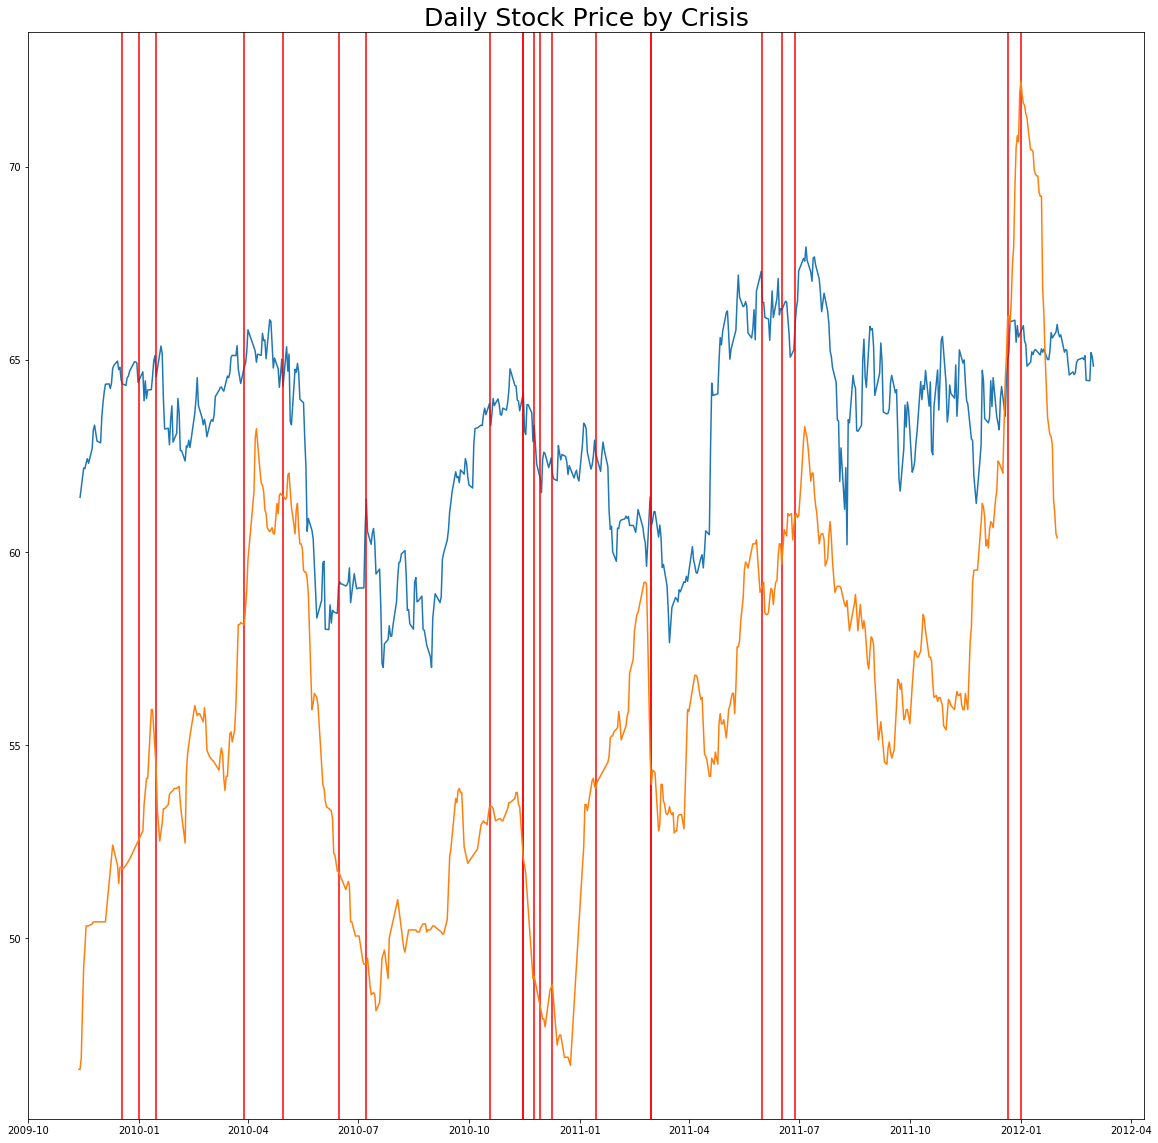

In [250]:
daily_filt = daily[daily['Date']>pd.to_datetime('2009-11-12')]
rel_tweet_ma = minmax_scale(np.array(df['MA']), (46.6, 72.22))
plt.figure(figsize=(20,20))
plt.plot(daily_filt['Date'], daily_filt['Last Px'])
for i in lle_txt['Date ']:
    plt.axvline(i, color='r')
plt.plot(df['created_at'], rel_tweet_ma)
plt.title('Daily Stock Price by Crisis', size =25)

In [257]:
min_date = min(daily_filt['Date']) 
max_date = max(daily_filt['Date'])

df_cp = df.copy()
print(df_cp.head())
# Get it to a daily avg
df_cp = df_cp[df_cp['created_at']>=min_date]
df_cp = df_cp[df_cp['created_at']<=max_date]

df_cp['sent'] = df['text'].apply(lambda x: get_valence(x))
df_cp = df_cp.groupby('created_at').apply(sum).drop(columns=['tweet_id', 'text', 'author_id', 'is_JNJ', 'MA'])

  created_at            tweet_id  \
0 2012-01-31  164441093432295425   
1 2012-01-31  164438417294376960   
2 2012-01-31  164433423547629569   
3 2012-01-31  164428792356548608   
4 2012-01-31  164413149787860994   

                                                text  author_id  is_JNJ   MA  
0  @Amgen @JNJComm \n“Amgen takes first place fro...  176742975       0  329  
1  7 Tips from Lawrence Hrebiniak, former consult...   18319419       0  329  
2  RT @JNJComm: #JNJ announces partnership combat...  104573125       0  329  
3  #JNJ announces partnership combat neglected tr...   20457806       0  329  
4  RT @JNJComm: New Healthy Vision podcast sponso...   71335555       0  329  


In [258]:
new_dates = [i for i in daily_filt['Date'] if i not in df_cp.index]

print(len(new_dates))

for i in new_dates:
    df_cp.loc[i] = np.nan
    
#sort_values('created_at')
df_cp = df_cp.ffill()

df_cp.isna().value_counts()

132


sent 
False    675
dtype: int64

In [259]:
# collapse weekends to monday
if len(df_cp.columns)<2:
    df_cp = df_cp.reset_index()
count=0
df_cp['groupby_idx'] = 0
df_hash = {}
print(df_cp.head())
for i in range(df_cp.shape[0]):
    if df_cp.loc[i,'created_at'].weekday()==5:
        df_cp.loc[i,'groupby_idx']= count+2
    elif df_cp.loc[i,'created_at'].weekday()==6:
        df_cp.loc[i,'groupby_idx'] = count+1
    else:
        df_cp.loc[i,'groupby_idx'] = count
    df_hash[ df_cp.loc[i,'groupby_idx']] =  df_cp.loc[i,'created_at']
    count+=1
    
df_cp = df_cp.groupby('groupby_idx').apply(sum).drop(columns='groupby_idx')
df_cp = df_cp.reset_index()
df_cp['created_at'] = df_cp['groupby_idx'].apply(lambda x: df_hash[x])
df_cp = df_cp.drop(columns='groupby_idx')

  created_at      sent  groupby_idx
0 2009-11-13  0.105303            0
1 2009-11-14  1.617888            0
2 2009-11-15  0.066667            0
3 2009-11-16  0.136364            0
4 2009-11-17  0.000000            0


In [290]:
## VAR 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

#def difference(data):
#    forward = [0] + list(data[1:])
#    print(len(forward))
#    print(len(data))
#    result = data - forward
#    result[0] = 0
#    return result

# Clean plz
price = daily_filt['Last Px']
price = np.array(price.reset_index().drop(columns='index')).reshape(-1,)
unique_date = daily_filt['Date'].unique()
sent = df_cp['created_at']
sent = np.array(sent.reset_index().drop(columns='index')).reshape(-1,)
sent = [i for i in sent if i in unique_date]
print(price.shape)
print(len(sent))

# tweet SA stationarity
print('Tweet Stationarity: ', sm.tsa.stattools.adfuller(difference(sent), autolag='AIC'))

# Price stationarity
print('Price Stationarity: ', sm.tsa.stattools.adfuller(difference(price), autolag='AIC'))

dif_tweet = difference(sent)
dif_price = difference(price)


(578,)
578
Tweet Stationarity:  (-23.678146429420167, 0.0, 0, 576, {'1%': -3.441753961421302, '5%': -2.866570853087291, '10%': -2.5694492998890817}, 41259.79057021128)
Price Stationarity:  (-11.99774614782387, 3.4026321301596308e-22, 4, 572, {'1%': -3.441834071558759, '5%': -2.8666061267054626, '10%': -2.569468095872659}, 971.0889702734099)


In [263]:
df_cp['created_at'] = pd.to_datetime(df_cp['created_at'])
print(daily_filt['Date'].dtype)
print(df_cp['created_at'].dtype)

print(df_cp['created_at'][0])
daily_filt = daily_filt.sort_values('Date')
print(daily_filt.head())
if 'Unnamed: 0' in daily_filt.columns:
    daily_filt=daily_filt.reset_index().drop(columns=['index', 'Unnamed: 0'])
df_cp.head()

datetime64[ns]
datetime64[ns]
2009-11-13 00:00:00
         Date  Last Px      Vol    SMAVG
Fr 2009-11-13    61.43   9.951M  12.688M
Mo 2009-11-16    62.19  13.768M  12.818M
Tu 2009-11-17    62.17  11.426M  12.895M
We 2009-11-18    62.32  11.523M  12.741M
Th 2009-11-19    62.43  13.298M  12.697M


,sent,created_at
0,0.105303,2009-11-13
1,1.820918,2009-11-16
2,0.000000,2009-11-17
3,0.984848,2009-11-18
4,0.000000,2009-11-19


In [301]:
# Granger
maxlag=1

temp_df = pd.DataFrame({'dif_tweet':dif_tweet,
                       'dif_price':dif_price})

test_result = grangercausalitytests((temp_df['dif_tweet'], temp_df['dif_price']), maxlag=1, verbose=False)



ValueError: Insufficient observations. Maximum allowable lag is -1

-------

## BERT

In [ ]:
# From https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [24]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures


model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [26]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [94]:
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

84131840/84125825 [==============================] - 58s 1us/step
['urls_unsup.txt', 'urls_pos.txt', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'neg']


Maybe 

In [101]:
# We create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split.
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [100]:
type(train)

pandas.core.frame.DataFrame

In [102]:
for i in train.take(1):
    train_feat = i[0].numpy()
    train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")

for j in test.take(1):
    test_feat = j[0].numpy()
    test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,I can't believe that so much talent can be was...,0
1,This movie blows - let's get that straight rig...,0
2,"The saddest thing about this ""tribute"" is that...",0
3,I'm only rating this film as a 3 out of pity b...,0
4,Something surprised me about this movie - it w...,1


In [103]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    return train_InputExamples, validation_InputExamples

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [104]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Training

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

In [ ]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']

In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": \n", labels[label[i]])

----------

## Numberbatch Encoder

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
NUM_TOP_WORDS = None 
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(factiva_df.articles)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(factiva_df.articles)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))


Found 4581 unique tokens. Distilled to 4581 top words.


In [38]:
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open("/home/hank/Downloads/coding_dls/numberbatch/numberbatch-en.txt", encoding="utf-8")

#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1
    else:
        print(word)
        

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 516783 word vectors.
Embedding Shape: (4582, 300) 
 Total words found: 3842 
 Percentage: 83.84984722828459
